In [127]:

import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


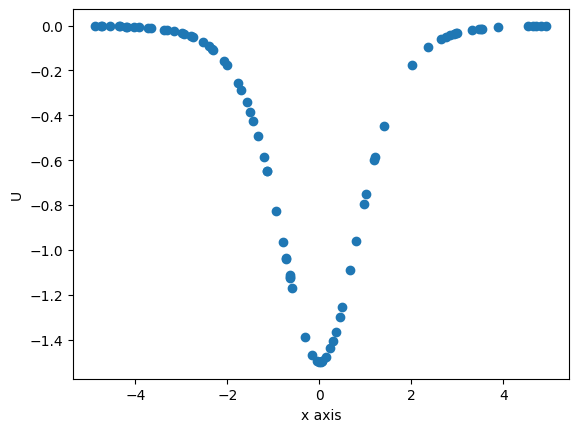

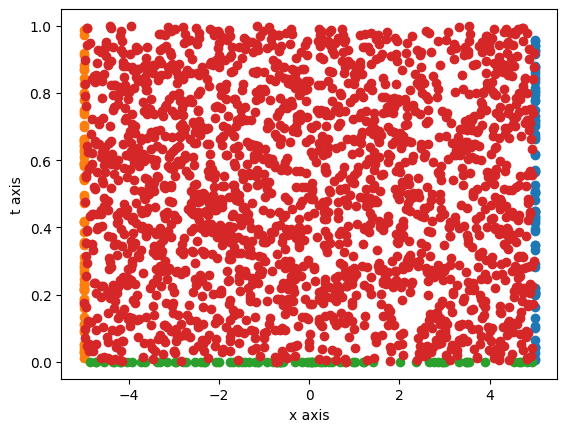

In [ ]:
x_min = -5
x_max = 5
t_min = 0
t_max = 1

N_0 = 80
N_b = 85
N_r = 2000
np.random.seed(2)

#initial at U(x, t=0)
x_0 = np.random.uniform(low=x_min, high=x_max, size=(N_0, 1))
t_0 = np.ones((N_0, 1), dtype=np.float64)*t_min
c = 3
U_0 = -0.5*c* 1/(np.cosh( 0.5*np.sqrt(c)*(x_0 -c*t_min) )**2) # initial condition
#U_0 = 0.5*c* 1/(np.cosh( 0.5*np.sqrt(c)*(x_0 -c*t_min)**2))

t_b1 = np.random.uniform(low=t_min, high=t_max, size=(N_b, 1))
x_b1 = np.ones((N_b, 1), dtype=np.float64)*x_min
U_b1 = np.ones((N_b, 1), dtype=np.float64)*0

t_b2 = np.random.uniform(low=t_min, high=t_max, size=(N_b, 1))
x_b2 = np.ones((N_b, 1), dtype=np.float64)*x_max
U_b2 = np.ones((N_b, 1), dtype=np.float64)*0


x_c = np.random.uniform(low=x_min, high=x_max, size=(N_r, 1))
t_c = np.random.uniform(low=t_min, high=t_max, size=(N_r, 1))



plt.scatter(x_0, U_0)
plt.xlabel("x axis")
plt.ylabel("U")
plt.show()
plt.scatter(x_b2, t_b2)
plt.scatter(x_b1, t_b1)
plt.scatter(x_0, t_0)
plt.scatter(x_c, t_c)
plt.xlabel("x axis")
plt.ylabel("t axis")
plt.show()

In [129]:
"""
#inputs = 2 (x,t)
and #outputs = 1 (u)

We can add as many hidden layers as we want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
5 hidden layer with 10 neurons each.
one input layer(2,5)
one output layer(5,1)
"""

class Neural_network(nn.Module):
  def __init__(self):
    super(Neural_network, self).__init__()
    self.input_layer = nn.Linear(2,20)
    self.hidden_layer1 = nn.Linear(20,20)
    self.hidden_layer2 = nn.Linear(20,20)
    self.hidden_layer3 = nn.Linear(20,20)
    self.hidden_layer4 = nn.Linear(20,20)
    self.hidden_layer5 = nn.Linear(20,20)
    self.hidden_layer6 = nn.Linear(20,20)
    self.hidden_layer7 = nn.Linear(20,20)
    self.hidden_layer8 = nn.Linear(20,20)
    self.output_layer = nn.Linear(20,1)

  def forward(self, x):
    #lb = torch.from_numpy(np.array([-1,-1])).to(device)
    #ub = torch.from_numpy(np.array([1,1])).to(device)
    #x = (x - lb)/(ub - lb)
    x = self.input_layer(x)
    x = torch.tanh(x)
    x = torch.tanh(self.hidden_layer1(x))
    x = torch.tanh(self.hidden_layer2(x))
    x = torch.tanh(self.hidden_layer3(x))
    x = torch.tanh(self.hidden_layer4(x))
    x = torch.tanh(self.hidden_layer5(x))
    #x = torch.tanh(self.hidden_layer6(x))
    #x = torch.tanh(self.hidden_layer7(x))
    #x = torch.tanh(self.hidden_layer8(x))
    x = self.output_layer(x)
    return x

In [130]:
Net = Neural_network()
Net = Net.to(device)
loss_fu = nn.MSELoss()
optim = torch.optim.Adam(Net.parameters(), lr=0.0005)

In [131]:
#initail
x_01 = torch.autograd.Variable( torch.from_numpy(x_0).float(), requires_grad=False).to(device)
t_01 = torch.autograd.Variable( torch.from_numpy(t_0).float(), requires_grad=False).to(device)
U_01 = torch.autograd.Variable( torch.from_numpy(U_0).float(), requires_grad=False).to(device)
X_0 = torch.cat([x_01, t_01], axis=1)

#BC1
x_b11 = torch.autograd.Variable( torch.from_numpy(x_b1).float(), requires_grad=True).to(device)
t_b11 = torch.autograd.Variable( torch.from_numpy(t_b1).float(), requires_grad=False).to(device)
U_b11 = torch.autograd.Variable( torch.from_numpy(U_b1).float(), requires_grad=False).to(device)
X_b1 = torch.cat([x_b11, t_b11], axis=1)

#BC2
x_b21 = torch.autograd.Variable( torch.from_numpy(x_b2).float(), requires_grad=True).to(device)
t_b21 = torch.autograd.Variable( torch.from_numpy(t_b2).float(), requires_grad=False).to(device)
U_b21 = torch.autograd.Variable( torch.from_numpy(U_b2).float(), requires_grad=False).to(device)
X_b2 = torch.cat([x_b21, t_b21], axis=1)

In [132]:
def pde(x, t, Net):
  x_1 = torch.autograd.Variable( torch.from_numpy(x).float(), requires_grad=True).to(device)
  t_1 = torch.autograd.Variable( torch.from_numpy(t).float(), requires_grad=True).to(device)
  X = torch.cat([x_1, t_1], axis=1)

  u = Net.forward(X)

  u_x = torch.autograd.grad(u.sum(), x_1, create_graph=True)[0]
  u_t = torch.autograd.grad(u.sum(), t_1, create_graph=True)[0]
  u_xx = torch.autograd.grad(u_x.sum(), x_1, create_graph=True)[0]
  u_xxx = torch.autograd.grad(u_xx.sum(), x_1, create_graph=True)[0]
  pde1 = u_t + u_xxx - 6*u*u_x
  return pde1

In [133]:
#LBFGS
"""
optim_LBFGGS = torch.optim.LBFGS(Net.parameters(), lr=0.01)
def closure():
  optim_LBFGGS.zero_grad()
  u_pred_0 = Net.forward(X_0)     #forward pass
  Loss_initial = loss_fu(u_pred_0, U_01 )    # loss of initial

  u_pred_b1 = Net.forward(X_b1)
  Loss_b1 = loss_fu(u_pred_b1, U_b11)

  u_pred_b2 = Net.forward(X_b2)
  Loss_b2 = loss_fu(u_pred_b2, U_b21)

  pdee = pde(x_c, t_c, Net)                # pde losss
  Loss_pde = torch.linalg.norm(pdee)

  total_loss = Loss_initial + Loss_pde + Loss_b1 + Loss_b2      # total loss

  total_loss.backward()
  #if epoch%1000==0:
   #   print(f'epoch:{epoch}, loss:{total_loss.item():.4f}')
  return total_loss

for epoch in range(10000):
  optim_LBFGGS.step(closure)
"""


"\noptim_LBFGGS = torch.optim.LBFGS(Net.parameters(), lr=0.01)\ndef closure():\n  optim_LBFGGS.zero_grad()\n  u_pred_0 = Net.forward(X_0)     #forward pass\n  Loss_initial = loss_fu(u_pred_0, U_01 )    # loss of initial\n\n  u_pred_b1 = Net.forward(X_b1)\n  Loss_b1 = loss_fu(u_pred_b1, U_b11)\n\n  u_pred_b2 = Net.forward(X_b2)\n  Loss_b2 = loss_fu(u_pred_b2, U_b21)\n\n  pdee = pde(x_c, t_c, Net)                # pde losss\n  Loss_pde = torch.linalg.norm(pdee)\n\n  total_loss = Loss_initial + Loss_pde + Loss_b1 + Loss_b2      # total loss\n\n  total_loss.backward()\n  #if epoch%1000==0:\n   #   print(f'epoch:{epoch}, loss:{total_loss.item():.4f}')\n  return total_loss\n\nfor epoch in range(10000):\n  optim_LBFGGS.step(closure)\n"

epoch:0, loss:0.46970505
epoch:100, loss:0.18071845
epoch:200, loss:0.08730970
epoch:300, loss:0.04514093
epoch:400, loss:0.02995271
epoch:500, loss:0.02476898
epoch:600, loss:0.02305521
epoch:700, loss:0.02203974
epoch:800, loss:0.02081151
epoch:900, loss:0.02008095
epoch:1000, loss:0.01937446
epoch:1100, loss:0.01891891
epoch:1200, loss:0.01847521
epoch:1300, loss:0.01813521
epoch:1400, loss:0.01783105
epoch:1500, loss:0.01755729
epoch:1600, loss:0.01736680
epoch:1700, loss:0.01729729
epoch:1800, loss:0.01648028
epoch:1900, loss:0.01675727
epoch:2000, loss:0.01657513
epoch:2100, loss:0.01653031
epoch:2200, loss:0.01638071
epoch:2300, loss:0.01627071
epoch:2400, loss:0.01614208
epoch:2500, loss:0.01605593
epoch:2600, loss:0.01596412
epoch:2700, loss:0.01585870
epoch:2800, loss:0.01579171
epoch:2900, loss:0.01563261
epoch:3000, loss:0.01557096
epoch:3100, loss:0.01547087
epoch:3200, loss:0.01552100
epoch:3300, loss:0.01543750
epoch:3400, loss:0.01542154
epoch:3500, loss:0.01536213
epoc

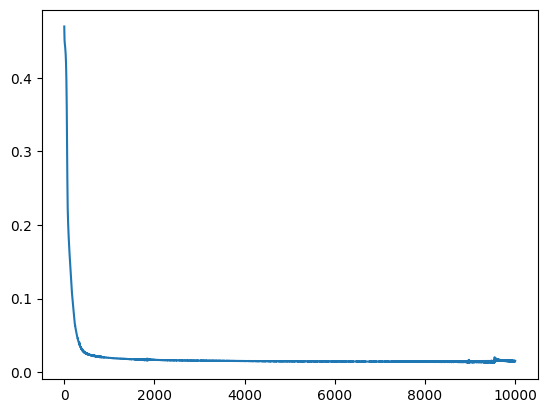

In [134]:
number_of_epoch =10000
looss=[]
for epoch in range(number_of_epoch):
  optim.zero_grad()       # make the gradient zero

  u_pred_0 = Net.forward(X_0)     #forward pass
  Loss_initial = loss_fu(u_pred_0, U_01 )    # loss of initial

  u_pred_b1 = Net.forward(X_b1)
  Loss_b1 = loss_fu(u_pred_b1, U_b11)

  u_pred_b2 = Net.forward(X_b2)
  Loss_b2 = loss_fu(u_pred_b2, U_b21)

  U_b1_derivative = torch.autograd.grad(u_pred_b1.sum(), x_b11, create_graph=True)[0]
  U_b2_derivative = torch.autograd.grad(u_pred_b2.sum(), x_b21, create_graph=True)[0]
  loss_b_deriv1 = loss_fu(U_b1_derivative, U_b21)
  loss_b_deriv2 = loss_fu(U_b2_derivative, U_b21)

  U_b1_derivative_x = torch.autograd.grad(U_b1_derivative.sum(), x_b11, create_graph=True)[0]
  U_b2_derivative_x = torch.autograd.grad(U_b2_derivative.sum(), x_b21, create_graph=True)[0]
  loss_b_deriv1_x = loss_fu(U_b1_derivative_x, U_b21)
  loss_b_deriv2_x = loss_fu(U_b2_derivative_x, U_b21)




  pdee = pde(x_c, t_c, Net)                # pde losss
  Loss_pde = torch.linalg.norm(pdee)

  total_loss = Loss_initial + 0.01*Loss_pde + Loss_b1 + Loss_b2 + loss_b_deriv1 + loss_b_deriv2 + loss_b_deriv1_x + loss_b_deriv2_x      # total loss

  total_loss.backward()    # computing gradients using backward propagation  dL/dw
  optim.step()             # This is equivalent to : Weight_new = weight_old - learing_rate * derivative of Loss w.r.t weight

  looss.append(total_loss.item())
  with torch.autograd.no_grad():
    if epoch%100==0:
      print(f'epoch:{epoch}, loss:{total_loss.item():.8f}')
plt.plot(looss)

In [135]:
l=0
n=len(looss)
for i in looss:
    l+=i**2/n
np.sqrt(l)

0.04191391735989454

In [136]:
#plot
N =100
x_space = np.linspace(x_min, x_max, N)
t_space = np.linspace(t_min, t_max, N)
XX, TT = np.meshgrid(x_space, t_space)

X = np.hstack((XX.flatten()[:, None], TT.flatten()[:, None]))
X_tensor = torch.from_numpy(X).float().to(device)
U_pred = Net.forward(X_tensor).cpu().detach().numpy().reshape(N, N) # if use GPU
#U_pred = Net.forward(X_tensor).detach().numpy().reshape(N, N)

# from mpl_toolkits import mplot3d
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(8,6))
# ax = plt.axes(projection='3d')

# ax.plot_surface(XX, TT, U_pred, cmap="viridis")
# plt.show()

In [137]:
U_pred

array([[ 0.00643574,  0.00692436,  0.00739692, ...,  0.02691558,
         0.0255419 ,  0.02417663],
       [ 0.00645682,  0.00696318,  0.00745556, ...,  0.02668242,
         0.02530882,  0.02394229],
       [ 0.00647551,  0.00699845,  0.00751041, ...,  0.02644578,
         0.02507305,  0.02370562],
       ...,
       [ 0.00767602,  0.00880159,  0.00997478, ..., -0.08999128,
        -0.07734853, -0.06687313],
       [ 0.00773372,  0.00886264,  0.0100392 , ..., -0.09450281,
        -0.0812454 , -0.0702407 ],
       [ 0.0077927 ,  0.00892502,  0.01010501, ..., -0.09918989,
        -0.08529474, -0.07373989]], dtype=float32)

In [138]:
# for k in range(0,N, 5):
#   plt.plot(x_space, U_pred[k, :])
     

In [139]:
import numpy as np
import matplotlib.pyplot as plt
xx = np.linspace(-5,5,100)
tt = np.linspace(0,1,100)
cc=3
uu = -0.5*cc* 1/(np.cosh( 0.5*np.sqrt(cc)*(XX -cc*TT))**2)
uu_reshape = uu.reshape(100,100)

print(uu.shape)
print(uu_reshape.shape)

# for k in range(0,100, 10):
#   plt.plot(x_space, uu_reshape[k,:])
# plt.show()

# for k in range(0,100, 10):
#   plt.plot(x_space, U_pred[k,:])
# plt.show()

(100, 100)
(100, 100)


In [140]:
# plt.pcolor(XX, TT, U_pred)
# plt.title("predicted")
# plt.show()

# plt.pcolor(XX, TT, uu_reshape)
# plt.title("exact")
# plt.show()

# plt.pcolor(XX, TT, uu_reshape-U_pred)
# plt.title("error")
# plt.show()

In [141]:
error=uu_reshape-U_pred
error=error.flatten()
error

array([-0.00747542, -0.00816274, -0.00887195, ..., -0.14511323,
       -0.1226252 , -0.10283952])

In [142]:
l=np.sqrt(np.sum(error**2)/len(error))


In [143]:
l

0.1503996010272646